In [ ]:
import pandas as pd

df = pd.read_csv('offenseval.tsv', sep='\t')

print(df.columns)

label_column = 'subtask_a'

print("\nLabel counts:")
print(df[label_column].value_counts())
print("\nLabel percentages:")
print((df[label_column].value_counts(normalize=True) * 100).round(2))



Index(['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c'], dtype='object')

Label counts:
subtask_a
NOT    8840
OFF    4400
Name: count, dtype: int64

Label percentages:
subtask_a
NOT    66.77
OFF    33.23
Name: proportion, dtype: float64


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("offenseval.tsv", sep="\t")

# Preview
print(df.head())
print(df.shape)
print(df.columns)


      id                                              tweet subtask_a  \
0  86426  @USER She should ask a few native Americans wh...       OFF   
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2  16820  Amazon is investigating Chinese employees who ...       NOT   
3  62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4  43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   

  subtask_b subtask_c  
0       UNT       NaN  
1       TIN       IND  
2       NaN       NaN  
3       UNT       NaN  
4       NaN       NaN  
(13240, 5)
Index(['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c'], dtype='object')


In [ ]:
# Keep only tweet and subtask_a
df = df[['tweet', 'subtask_a']]

# Drop missing values if any
df.dropna(inplace=True)

df.head()


,tweet,subtask_a
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [ ]:
df['label'] = df['subtask_a'].map({'OFF': 1, 'NOT': 0})

df.head()
df['label'].value_counts()


,count
label,
0,8840
1,4400


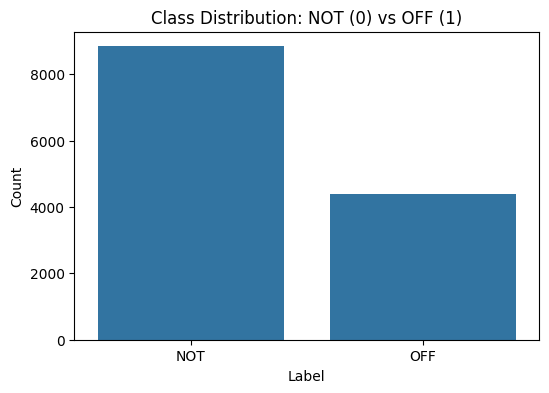

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=df['label'])
plt.title("Class Distribution: NOT (0) vs OFF (1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0,1], ['NOT', 'OFF'])
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['tweet'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)


In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)     # remove links
    text = re.sub(r'@\w+', '', text)             # remove mentions
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)     # remove special chars
    text = re.sub(r'\s+', ' ', text).strip()     # remove extra spaces
    return text

X_train_clean = X_train.apply(clean_text)
X_test_clean  = X_test.apply(clean_text)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),     # word uni + bi-grams
    analyzer='word',
    min_df=5,
    max_df=0.95,
    sublinear_tf=True
)

X_train_vec = vectorizer.fit_transform(X_train_clean)
X_test_vec = vectorizer.transform(X_test_clean)

X_train_vec.shape, X_test_vec.shape


((10592, 8141), (2648, 8141))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=300)
lr.fit(X_train_vec, y_train)
lr_pred = lr.predict(X_test_vec)

print("Logistic Regression Results:")
print(classification_report(y_test, lr_pred))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      1768
           1       0.79      0.36      0.49       880

    accuracy                           0.75      2648
   macro avg       0.77      0.66      0.67      2648
weighted avg       0.76      0.75      0.72      2648



In [ ]:
from sklearn.svm import LinearSVC

svm_linear = LinearSVC(C=1.0)
svm_linear.fit(X_train_vec, y_train)
linear_pred = svm_linear.predict(X_test_vec)

print("Linear SVM Results:")
print(classification_report(y_test, linear_pred))


Linear SVM Results:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1768
           1       0.63      0.52      0.57       880

    accuracy                           0.74      2648
   macro avg       0.70      0.68      0.69      2648
weighted avg       0.73      0.74      0.73      2648



In [ ]:
from sklearn.svm import SVC

svm_rbf = SVC(kernel='rbf', gamma='scale', C=1.0)
svm_rbf.fit(X_train_vec, y_train)
rbf_pred = svm_rbf.predict(X_test_vec)

print("RBF SVM Results:")
print(classification_report(y_test, rbf_pred))


RBF SVM Results:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      1768
           1       0.81      0.31      0.45       880

    accuracy                           0.75      2648
   macro avg       0.78      0.64      0.65      2648
weighted avg       0.76      0.75      0.71      2648



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01, 0.001]
}

svm_rbf = SVC(kernel='rbf')

grid = GridSearchCV(
    svm_rbf,
    param_grid,
    cv=3,
    scoring='f1',
    verbose=2
)

grid.fit(X_train_vec, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_svm = grid.best_estimator_
best_pred = best_svm.predict(X_test_vec)

print("Best Tuned RBF SVM Results:")
print(classification_report(y_test, best_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .....................................C=0.1, gamma=1; total time=  32.7s
[CV] END .....................................C=0.1, gamma=1; total time=  17.0s
[CV] END .....................................C=0.1, gamma=1; total time=  18.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=  15.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=  16.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=  15.6s
[CV] END ..................................C=0.1, gamma=0.01; total time=  14.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=  13.6s
[CV] END ..................................C=0.1, gamma=0.01; total time=  13.4s
[CV] END .................................C=0.1, gamma=0.001; total time=  12.3s
[CV] END .................................C=0.1, gamma=0.001; total time=  12.5s
[CV] END .................................C=0.1,

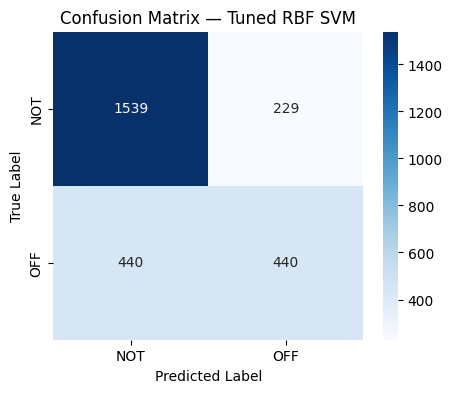

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NOT','OFF'],
            yticklabels=['NOT','OFF'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix — Tuned RBF SVM')
plt.show()


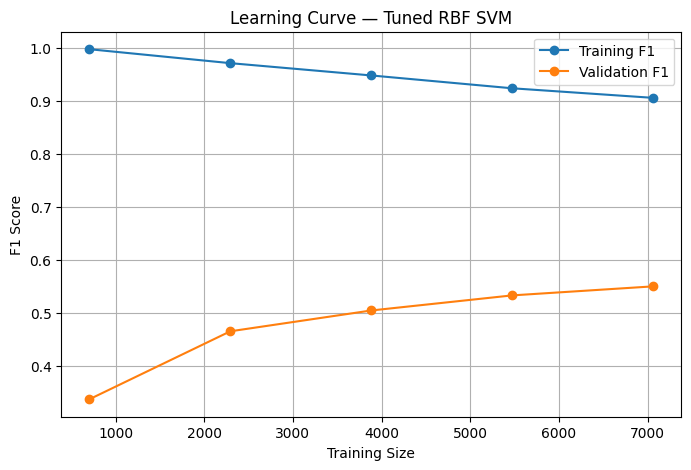

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_svm,
    X_train_vec,
    y_train,
    cv=3,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, marker='o', label='Training F1')
plt.plot(train_sizes, test_mean, marker='o', label='Validation F1')
plt.title("Learning Curve — Tuned RBF SVM")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()
